In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import AutoImageProcessor, AutoModelForImageClassification

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix

### Loading FashionMNIST Dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel to 3-channel
    transforms.ToTensor()            # Convert to tensor
])

train_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

### Preparing data for training with DataLoaders

In [3]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Vision Transformer

In [4]:
# Initialize ViT with custom classifier
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
model.classifier = nn.Linear(model.config.hidden_size, 10)

In [5]:
# Freeze all layers except classifier
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [6]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

classifier.weight
classifier.bias


In [7]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85806346
Trainable parameters: 7690


### Model Training

In [8]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
earlystopper = EarlyStopper()

In [ ]:
# Load model from Checkpoint for continued training
# model = torch.load('ViT_base_mixup.pth', weights_only=False)
# model.to(device);

In [ ]:
# Training function
def train(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    mixup = transforms.v2.MixUp(num_classes=10)
    
    loop = tqdm(loader, desc=f"Epoch {epoch}", leave=False)
    for images, labels in loop:
        # Apply MixUp augmentation
        images, labels = mixup(images, labels)
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        class_labels = torch.argmax(labels, dim=1)
        correct += predicted.eq(class_labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    loss /= total
    acc = 100.0 * correct / total
    return loss, acc

In [ ]:
best_val_acc = 0.0 
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train for several epochs
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, epoch)
    val_loss, val_acc = evaluate(model, test_dataloader, criterion)
    
    # Store the values for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(val_loss)
    test_accuracies.append(val_acc)

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, "ViT_base_mixup.pth")
        print(f"Best model saved at epoch {epoch} with Val Acc: {val_acc:.2f}%")
    
    if earlystopper.early_stop(val_loss):
        break

[Epoch 1] Train Loss: 1.3586 | Train Acc: 66.29% | Val Loss: 0.5669 | Val Acc: 84.39%
Best model saved at epoch 1 with Val Acc: 84.39%


[Epoch 2] Train Loss: 1.1171 | Train Acc: 74.90% | Val Loss: 0.4998 | Val Acc: 85.89%
Best model saved at epoch 2 with Val Acc: 85.89%


[Epoch 3] Train Loss: 1.1016 | Train Acc: 75.86% | Val Loss: 0.4768 | Val Acc: 86.64%
Best model saved at epoch 3 with Val Acc: 86.64%


[Epoch 4] Train Loss: 1.0636 | Train Acc: 76.26% | Val Loss: 0.4587 | Val Acc: 87.31%
Best model saved at epoch 4 with Val Acc: 87.31%


[Epoch 5] Train Loss: 1.0387 | Train Acc: 77.39% | Val Loss: 0.4457 | Val Acc: 87.37%
Best model saved at epoch 5 with Val Acc: 87.37%


[Epoch 6] Train Loss: 1.0409 | Train Acc: 76.66% | Val Loss: 0.4383 | Val Acc: 87.73%
Best model saved at epoch 6 with Val Acc: 87.73%


[Epoch 7] Train Loss: 1.0272 | Train Acc: 77.72% | Val Loss: 0.4312 | Val Acc: 88.01%
Best model saved at epoch 7 with Val Acc: 88.01%


[Epoch 8] Train Loss: 1.0125 | Train Acc: 77.60% | Val Loss: 0.4224 | Val Acc: 88.00%


[Epoch 9] Train Loss: 1.0106 | Train Acc: 77.60% | Val Loss: 0.4175 | Val Acc: 88.25%
Best model saved at epoch 9 with Val Acc: 88.25%


[Epoch 10] Train Loss: 1.0038 | Train Acc: 77.71% | Val Loss: 0.4117 | Val Acc: 88.30%
Best model saved at epoch 10 with Val Acc: 88.30%


[Epoch 11] Train Loss: 1.0063 | Train Acc: 77.87% | Val Loss: 0.4102 | Val Acc: 88.44%
Best model saved at epoch 11 with Val Acc: 88.44%


[Epoch 12] Train Loss: 1.0067 | Train Acc: 77.75% | Val Loss: 0.4066 | Val Acc: 88.47%
Best model saved at epoch 12 with Val Acc: 88.47%


[Epoch 13] Train Loss: 0.9970 | Train Acc: 77.71% | Val Loss: 0.4079 | Val Acc: 88.65%
Best model saved at epoch 13 with Val Acc: 88.65%


[Epoch 14] Train Loss: 0.9822 | Train Acc: 78.51% | Val Loss: 0.4065 | Val Acc: 88.45%


[Epoch 15] Train Loss: 0.9999 | Train Acc: 77.46% | Val Loss: 0.4043 | Val Acc: 88.51%


[Epoch 16] Train Loss: 0.9924 | Train Acc: 77.94% | Val Loss: 0.3998 | Val Acc: 88.65%


[Epoch 17] Train Loss: 0.9773 | Train Acc: 78.06% | Val Loss: 0.3956 | Val Acc: 88.79%
Best model saved at epoch 17 with Val Acc: 88.79%


[Epoch 18] Train Loss: 0.9762 | Train Acc: 77.97% | Val Loss: 0.3947 | Val Acc: 88.71%


[Epoch 19] Train Loss: 0.9743 | Train Acc: 78.78% | Val Loss: 0.3935 | Val Acc: 88.84%
Best model saved at epoch 19 with Val Acc: 88.84%


[Epoch 20] Train Loss: 0.9802 | Train Acc: 77.59% | Val Loss: 0.3907 | Val Acc: 88.71%


[Epoch 21] Train Loss: 0.9768 | Train Acc: 77.74% | Val Loss: 0.3897 | Val Acc: 88.96%
Best model saved at epoch 21 with Val Acc: 88.96%


[Epoch 22] Train Loss: 0.9816 | Train Acc: 77.47% | Val Loss: 0.3891 | Val Acc: 88.96%


[Epoch 23] Train Loss: 0.9834 | Train Acc: 77.72% | Val Loss: 0.3888 | Val Acc: 88.91%


[Epoch 24] Train Loss: 0.9790 | Train Acc: 77.67% | Val Loss: 0.3894 | Val Acc: 88.87%


[Epoch 25] Train Loss: 0.9758 | Train Acc: 78.27% | Val Loss: 0.3861 | Val Acc: 88.85%


[Epoch 26] Train Loss: 0.9541 | Train Acc: 78.93% | Val Loss: 0.3843 | Val Acc: 88.88%


[Epoch 27] Train Loss: 0.9671 | Train Acc: 78.30% | Val Loss: 0.3836 | Val Acc: 88.89%


[Epoch 28] Train Loss: 0.9808 | Train Acc: 77.69% | Val Loss: 0.3863 | Val Acc: 88.91%


[Epoch 29] Train Loss: 0.9770 | Train Acc: 77.81% | Val Loss: 0.3832 | Val Acc: 88.98%
Best model saved at epoch 29 with Val Acc: 88.98%


[Epoch 30] Train Loss: 0.9793 | Train Acc: 78.06% | Val Loss: 0.3881 | Val Acc: 88.94%


[Epoch 31] Train Loss: 0.9713 | Train Acc: 77.53% | Val Loss: 0.3828 | Val Acc: 88.90%


[Epoch 32] Train Loss: 0.9587 | Train Acc: 78.43% | Val Loss: 0.3812 | Val Acc: 89.05%
Best model saved at epoch 32 with Val Acc: 89.05%


[Epoch 33] Train Loss: 0.9716 | Train Acc: 78.09% | Val Loss: 0.3816 | Val Acc: 88.99%


[Epoch 34] Train Loss: 0.9704 | Train Acc: 77.68% | Val Loss: 0.3791 | Val Acc: 89.00%


[Epoch 35] Train Loss: 0.9605 | Train Acc: 78.60% | Val Loss: 0.3813 | Val Acc: 88.86%


[Epoch 36] Train Loss: 0.9723 | Train Acc: 77.60% | Val Loss: 0.3767 | Val Acc: 89.13%
Best model saved at epoch 36 with Val Acc: 89.13%


[Epoch 37] Train Loss: 0.9564 | Train Acc: 78.38% | Val Loss: 0.3789 | Val Acc: 88.83%


[Epoch 38] Train Loss: 0.9771 | Train Acc: 77.12% | Val Loss: 0.3807 | Val Acc: 89.19%
Best model saved at epoch 38 with Val Acc: 89.19%


Epoch 39:  24%|██▍       | 224/938 [01:08<03:38,  3.26it/s, acc=77.6, loss=1.05] 

### Evaluation

In [ ]:
# Load model from Checkpoint
model = torch.load('ViT_base_mixup.pth', weights_only=False)
model.to(device);

In [ ]:
# Set up the figure
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.suptitle("ViT with MixUp", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig("Base3.png")  # Save as PNG
plt.show()

In [11]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))



Classification Report:
              precision    recall  f1-score   support

           0     0.8570    0.8330    0.8448      1000
           1     0.9889    0.9800    0.9844      1000
           2     0.8436    0.8630    0.8532      1000
           3     0.8252    0.9110    0.8660      1000
           4     0.8302    0.8460    0.8380      1000
           5     0.9631    0.9650    0.9640      1000
           6     0.7323    0.6510    0.6893      1000
           7     0.9275    0.9590    0.9430      1000
           8     0.9889    0.9770    0.9829      1000
           9     0.9642    0.9430    0.9535      1000

    accuracy                         0.8928     10000
   macro avg     0.8921    0.8928    0.8919     10000
weighted avg     0.8921    0.8928    0.8919     10000



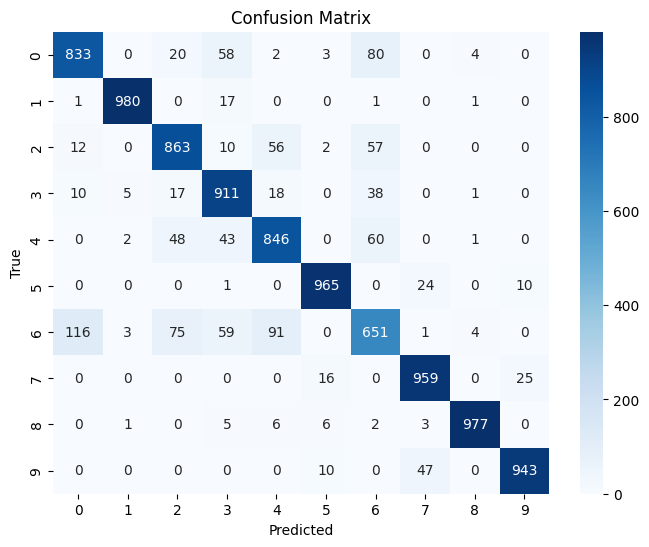

In [12]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()